Column names:["Date", "AAPL", "ABBV", "AMD", "AXP", "BA", "CAT", "DFS", "DIS", "ETN", "GOOG", "GS", "JNJ", "JPM", "META", "MRK", "MSFT", "NFLX", "NVDA", "PFE", "RTX", "SYF", "TMUS", "UBER", "UNH", "UNP"]
Type of column names:DataType[String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String, String]
Number of asset names:25
Length of μ:25
Size of Σ:(25, 25)
Number of assets (n_assets):25
This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       25
Number of nonzeros in inequality constraint Jacobian.:       25
Number of nonzeros in Lagrangian Hessian.............:      325

Total number of variables............................:       25
                     variables with only lower bounds:       25
                variables with lower and upper bounds:        0
           

LOCALLY_SOLVED::TerminationStatusCode = 4

The model is feasible.


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


Portfolio Expected Daily Return: 0.0007205890019164069
Portfolio Risk (Standard Deviation): 0.011419673822993151


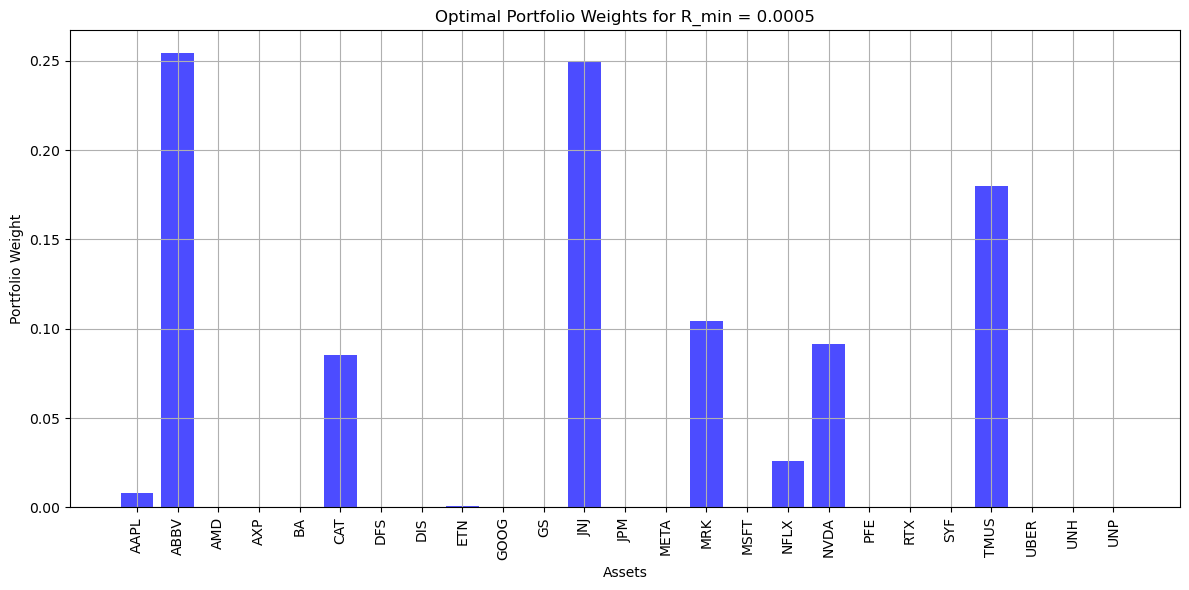

In [35]:
# --- Import Necessary Packages ---
using CSV, DataFrames, Dates, Statistics
using JuMP, Ipopt
using PyPlot
using LinearAlgebra

# --- Data Preparation ---

# Define the directory containing the stock CSV files
directory_path = "data_files/"

# Initialize an empty DataFrame to hold daily returns
returns_df = DataFrame(Date = Date[])

# Read each stock CSV file and compute daily returns
for file in readdir(directory_path)
    if endswith(file, ".csv")
        file_path = joinpath(directory_path, file)
        stock_df = CSV.read(file_path, DataFrame)

        # Ensure the Date column is of Date type
        stock_df.Date = Date.(string.(stock_df.Date), "yyyy-mm-dd")
        sort!(stock_df, :Date)

        stock_name = splitext(basename(file))[1]

        # Calculate daily logarithmic returns
        stock_df[!, :DailyReturn] = [missing; diff(log.(stock_df.Close))]

        # Create a DataFrame with Date and DailyReturn
        stock_returns = stock_df[:, [:Date, :DailyReturn]]
        rename!(stock_returns, :DailyReturn => stock_name)

        # Merge with the returns_df
        if nrow(returns_df) == 0
            returns_df = stock_returns
        else
            returns_df = outerjoin(returns_df, stock_returns, on = :Date)
        end
    end
end

# Remove rows with missing values
complete_cases = dropmissing(returns_df, disallowmissing=true)

# --- Extract Asset Names and Prepare Data ---

# Extract asset names excluding the Date column
# Check the type of column names
col_names = names(complete_cases)
println("Column names:", col_names)
println("Type of column names:", typeof.(col_names))

# Adjust based on the type
if eltype(col_names) == String
    asset_names = setdiff(col_names, ["Date"])
elseif eltype(col_names) == Symbol
    asset_names = setdiff(col_names, [:Date])
else
    error("Unexpected column name types.")
end

# Convert asset_names to strings if necessary
asset_names = string.(asset_names)

# Verify lengths
println("Number of asset names:", length(asset_names))

# Extract the matrix of returns (excluding the Date column)
returns_matrix = Matrix(complete_cases[:, asset_names])

# --- Compute Expected Returns and Covariance Matrix ---

# Compute expected returns (mean daily returns)
μ = mean(returns_matrix, dims=1)
μ = vec(μ)  # Convert to a vector

# Verify length of μ
println("Length of μ:", length(μ))

# Compute covariance matrix
Σ = cov(returns_matrix, dims=1)

# Verify size of Σ
println("Size of Σ:", size(Σ))

# Number of assets
n_assets = length(μ)
println("Number of assets (n_assets):", n_assets)

# --- Portfolio Optimization ---

# Set a realistic minimum expected return (e.g., target daily return)
R_min = 0.0005  # Adjust based on your desired target return
λ = 10           # Risk aversion parameter

# Create optimization model
m = Model(Ipopt.Optimizer)

@variable(m, x[1:n_assets] >= 0)
@constraint(m, sum(x) == 1)
@constraint(m, μ' * x >= R_min)
@objective(m, Min, -(μ' * x) + λ *(x' * Σ * x))  # Minimize portfolio variance

# Solve the model
optimize!(m)

# Check solution status
status = termination_status(m)
display(status)

if status == MOI.OPTIMAL || status == MOI.LOCALLY_SOLVED
    println("The model is feasible.")

    # Extract optimal portfolio weights
    portfolio_weights = value.(x)

    # Compute portfolio return and risk
    portfolio_return = μ' * portfolio_weights
    portfolio_risk = sqrt(portfolio_weights' * Σ * portfolio_weights)  # Standard deviation

    # --- Plotting ---

    figure(figsize=(12, 6))
    bar(1:n_assets, portfolio_weights, color="blue", alpha=0.7)
    xticks(1:n_assets, asset_names, rotation=90)
    xlabel("Assets")
    ylabel("Portfolio Weight")
    title("Optimal Portfolio Weights for R_min = $R_min")
    grid(true)
    tight_layout()
    show()

    # --- Display Portfolio Metrics ---

    println("Portfolio Expected Daily Return: $portfolio_return")
    println("Portfolio Risk (Standard Deviation): $portfolio_risk")
else
    println("The model is not feasible. Status: $status")
end
